In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from statistics import mean
from utils import *
sns.set_theme()
import ast
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from statistics import mean


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

Train Accuracy: 0.7488097753595436
Test Accuracy: 0.7491201310063852
Total time elapsed for prediction: 0.51
Train Accuracy: 0.7529487312820564
Test Accuracy: 0.7333566645976678
Total time elapsed for prediction: 0.57
Train Accuracy: 0.7464858716771575
Test Accuracy: 0.7584157631304393
Total time elapsed for prediction: 0.57
Train Accuracy: 0.7462200937981309
Test Accuracy: 0.7594656700254883
Total time elapsed for prediction: 0.56
Train Accuracy: 0.7500581904983583
Test Accuracy: 0.7441264642569433
Total time elapsed for prediction: 0.66


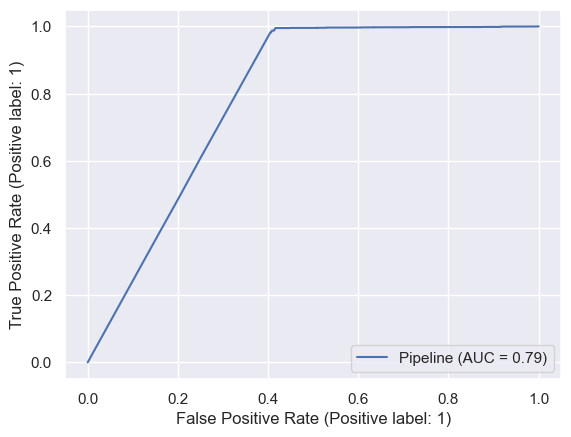

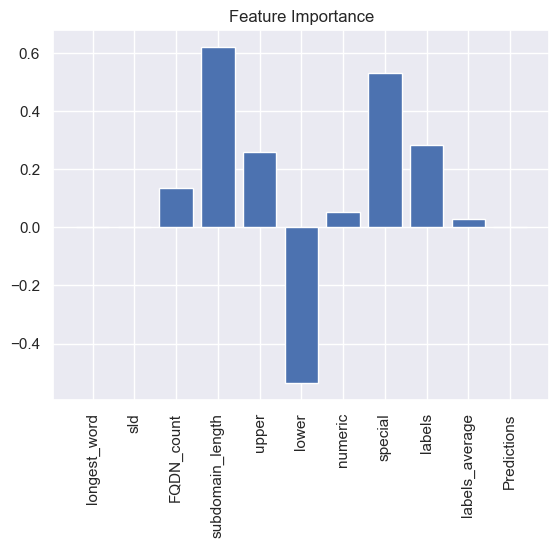

In [4]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index", \
                                "entropy", "labels_max", "len", "subdomain"]]]
y = stateless_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=300))
    ])    
    pipe.fit(X_train, y_train)
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += (prediction_time_end - prediction_time_start)
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
importance = pipe["lr"].coef_[0]

plt.bar([col for col in ["longest_word", "sld"]+[col for col in X if col not in ["longest_word", "sld"]]], importance)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

In [5]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 2.871
Time to evaluate a single data point: 0.00000379


## Overall Results

In [6]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.971257,0.607178,0.747228,462858.000000
1,0.611375,0.971745,0.750544,294353.000000
accuracy,0.748897,0.748897,0.748897,0.748897
macro avg,0.791316,0.789461,0.748886,757211.000000
weighted avg,0.831359,0.748897,0.748517,757211.000000


## Light-attack

In [7]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.970316,0.619594,0.756271,60091.000000
1,0.645063,0.973315,0.775900,42683.000000
accuracy,0.766497,0.766497,0.766497,0.766497
macro avg,0.807690,0.796454,0.766086,102774.000000
weighted avg,0.835236,0.766497,0.764423,102774.000000


## Heavy-attack

In [8]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.939374,0.612128,0.741239,181694.000000
1,0.776249,0.971479,0.862960,251670.000000
accuracy,0.820816,0.820816,0.820816,0.820816
macro avg,0.857811,0.791803,0.802099,433364.000000
weighted avg,0.844641,0.820816,0.811927,433364.000000


In [9]:
stateless_df.Predictions.value_counts(normalize=False)

1    467857
0    289354
Name: Predictions, dtype: int64

# Stateful Model Reimplementation

In [10]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Train Accuracy: 0.792048988000992
Test Accuracy: 0.7995459834799031
Total time elapsed for prediction: 0.41
Train Accuracy: 0.7958070239026345
Test Accuracy: 0.7845138398733332
Total time elapsed for prediction: 0.40
Train Accuracy: 0.7917389977299174
Test Accuracy: 0.7980198775299975
Total time elapsed for prediction: 0.44
Train Accuracy: 0.792783426489384
Test Accuracy: 0.793842162492131
Total time elapsed for prediction: 0.48
Train Accuracy: 0.7937277045458881
Test Accuracy: 0.7900650502661147
Total time elapsed for prediction: 0.47


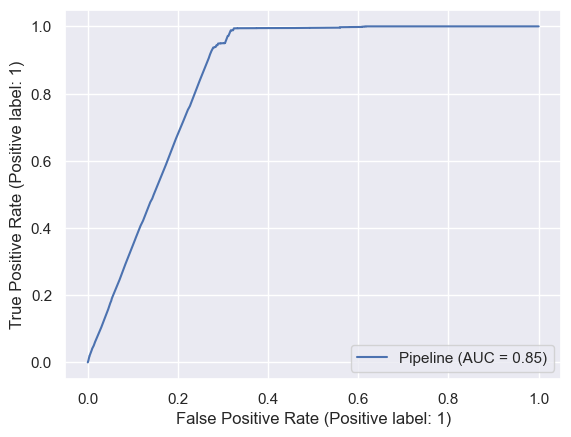

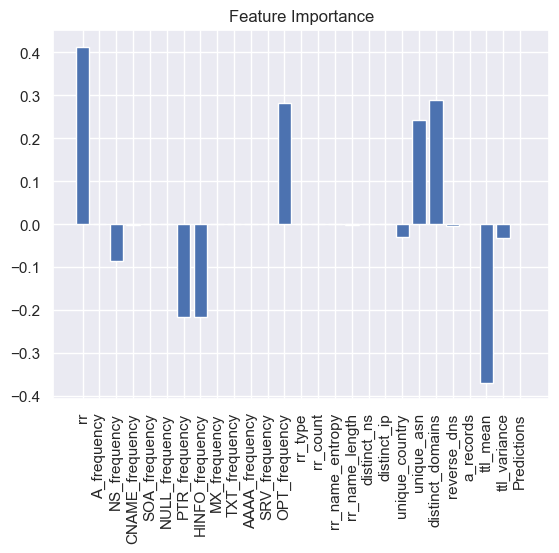

In [11]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=200))
    ])
    pipe.fit(X_train, y_train)
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateful_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateful += (prediction_time_end - prediction_time_start)
    
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    #display(pd.DataFrame(classification_report(y_test, pipe.predict(X_test), output_dict=True)).T)
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
importance = pipe["lr"].coef_[0]

plt.bar([col for col in X.columns], importance)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

In [12]:
print(f"Total prediction time for {stateful_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateful_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")

Total prediction time for 262105 rows is 2.187
Time to evaluate a single data point: 0.00000834


## Overall Results

In [13]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.961598,0.725800,0.827224,178782.000000
1,0.614495,0.937808,0.742482,83323.000000
accuracy,0.793197,0.793197,0.793197,0.793197
macro avg,0.788047,0.831804,0.784853,262105.000000
weighted avg,0.851254,0.793197,0.800284,262105.000000


## Light Attack Results

In [14]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.959074,0.729752,0.828844,22768.00000
1,0.632415,0.937229,0.755226,11295.00000
accuracy,0.798550,0.798550,0.798550,0.79855
macro avg,0.795745,0.833491,0.792035,34063.00000
weighted avg,0.850757,0.798550,0.804433,34063.00000


## Heavy Attack Results

In [15]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.917899,0.724600,0.809875,69016.000000
1,0.780423,0.937899,0.851945,72028.000000
accuracy,0.833527,0.833527,0.833527,0.833527
macro avg,0.849161,0.831250,0.830910,141044.000000
weighted avg,0.847693,0.833527,0.831360,141044.000000


In [16]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

# Two-step model

In [17]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7

In [18]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)

## Light attack

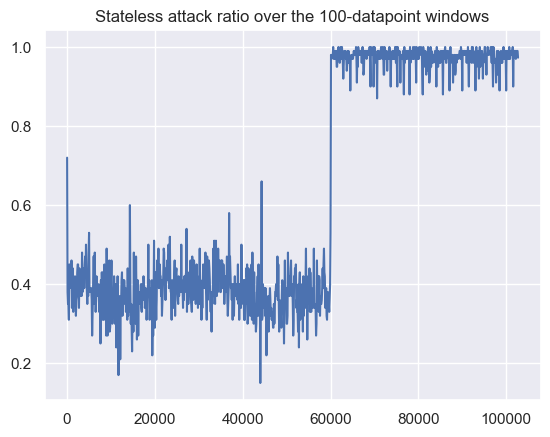

,precision,recall,f1-score,support
0,1.000000,0.956882,0.977966,60091.000000
1,0.942771,1.000000,0.970542,42683.000000
accuracy,0.974789,0.974789,0.974789,0.974789
macro avg,0.971385,0.978441,0.974254,102774.000000
weighted avg,0.976232,0.974789,0.974883,102774.000000


Total Estimated Time:  0.5799992737184108


In [19]:
two_step(stateless_df, stateful_df, is_light=True)

## Heavy attack

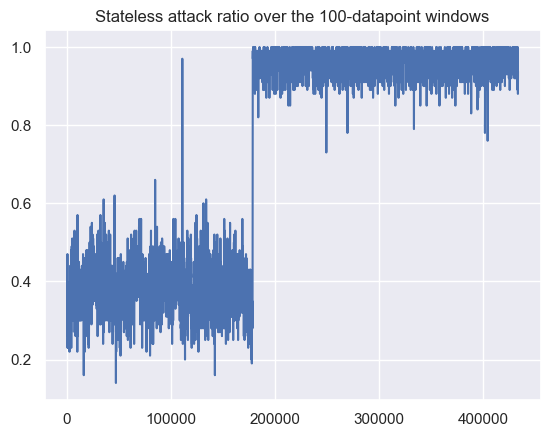

,precision,recall,f1-score,support
0,1.000000,0.936189,0.967043,181694.000000
1,0.955961,1.000000,0.977484,251670.000000
accuracy,0.973247,0.973247,0.973247,0.973247
macro avg,0.977980,0.968095,0.972264,433364.000000
weighted avg,0.974425,0.973247,0.973107,433364.000000


Total Estimated Time:  2.1947104001546465


In [20]:
two_step(stateless_df, stateful_df, is_light=False)

Some potentially useful libraries we could use:
https://github.com/irvinhomem/TunnelFeatureExtractor
https://github.com/lucadivit/Pcap_Features_Extraction

# Using RFE to select Features for the Stateless Model

In [32]:
stateless_df["Predictions"] = 0
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]

enc = OrdinalEncoder()
X[["longest_word","sld"]] = enc.fit_transform(X[["longest_word","sld"]])

y = stateless_df["attack"]

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe.fit(X, y)

for i, col in zip(range(X.shape[1]), X.columns):
    print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")

FQDN_count selected=True rank=1
subdomain_length selected=True rank=1
upper selected=False rank=2
lower selected=True rank=1
numeric selected=True rank=1
entropy selected=True rank=1
special selected=True rank=1
labels selected=False rank=3
labels_max selected=True rank=1
labels_average selected=True rank=1
longest_word selected=False rank=4
sld selected=False rank=5
len selected=True rank=1
subdomain selected=True rank=1
Predictions selected=False rank=6


Train Accuracy: 0.7498662854426117
Test Accuracy: 0.7497672391592877
Total time elapsed for prediction: 0.17
Train Accuracy: 0.7537460649191359
Test Accuracy: 0.7342282854161989
Total time elapsed for prediction: 0.18
Train Accuracy: 0.7474383799765257
Test Accuracy: 0.7594326540853924
Total time elapsed for prediction: 0.20
Train Accuracy: 0.7471313322405075
Test Accuracy: 0.7606674502449783
Total time elapsed for prediction: 0.18
Train Accuracy: 0.7524386358496391
Test Accuracy: 0.7462130716710028
Total time elapsed for prediction: 0.21


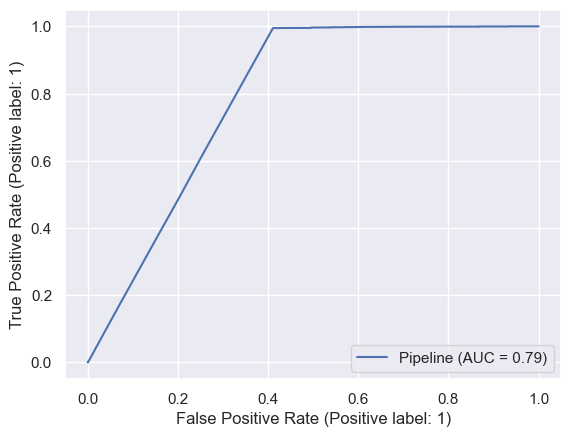

In [42]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index", \
                                "upper","labels","longest_word","sld","longest_word selected",\
                                "sld selected"]]]
y = stateless_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('scaler', StandardScaler(), [col for col in X_train])
    ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=300))
    ])    
    pipe.fit(X_train, y_train)
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += (prediction_time_end - prediction_time_start)
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
importance = pipe["lr"].coef_[0]



In [43]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 0.936
Time to evaluate a single data point: 0.00000124


In [45]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.981456,0.602498,0.746645,462858.000000
1,0.611080,0.982100,0.753388,294353.000000
accuracy,0.750062,0.750062,0.750062,0.750062
macro avg,0.796268,0.792299,0.750016,757211.000000
weighted avg,0.837479,0.750062,0.749266,757211.000000


## Rebuilding LR MODEL for Anova Feature Selection Technique

In [46]:
import glob
import numpy as np
import os
import time
import ast 
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report,RocCurveDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from statistics import mean
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve,auc, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
sns.set_theme()
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
train_time=0
pred_time=0
def lr_model(X_train,y_train,X_test,y_test):
    lr=LogisticRegression(random_state=0)
    start_trt = time.time()
    lr.fit(X_train,y_train)
    end_trt = time.time()
    print(f"Training Time [s]: {(end_trt-start_trt):.3f}")
    train_time=end_trt-start_trt
    y_train_pred =lr.predict(X_train)
    start_ts = time.time()
    y_pred = lr.predict(X_test)
    end_ts = time.time()
    train_score=accuracy_score(y_train, y_train_pred)
    test_score=accuracy_score(y_test, y_pred)
    cls_report=print("LR MODEL ",classification_report(y_test, y_pred, zero_division=1))
    roc_curve = plot_roc_curve(lr, X_test, y_test)
    print(f"Prediction Time [s]: {(end_ts-start_ts):.3f}")
    pred_time= end_ts-start_ts
    return train_score,test_score,train_time,pred_time

# Feature Engineering for the second technique

In [47]:
enc = LabelEncoder()
catcol_stateful=['rr_type', 'distinct_ip', 'unique_country', 'unique_asn', 'distinct_domains', 'reverse_dns']
catcol_stateless=['longest_word', 'sld', ]

indexsf = pd.Index(stateful_df['attack'])
print("stateful::\n",indexsf.value_counts())
indexsl = pd.Index(stateless_df['attack'])
print("stateless::\n",indexsl.value_counts())

for cols in catcol_stateful:
    stateful_df[cols] = enc.fit_transform(stateful_df[cols].astype(str))
for cols in catcol_stateless:
    stateless_df[cols] = enc.fit_transform(stateless_df[cols].astype(str))
X_stateful=stateful_df.drop(columns=['unique_ttl','attack','original_index','data_type','origin'],axis=1)
X_stateless=stateless_df.drop(columns=['attack','timestamp','original_index','data_type','origin'],axis=1)
y_stateful=stateful_df['attack']
y_stateless=stateless_df['attack']
y_stateful=y_stateful.to_frame()
y_stateless=y_stateless.to_frame()

mmsc=MinMaxScaler(feature_range=(0, 1))

X_stateless_scaled=mmsc.fit_transform(X_stateless)
X_stateless_scaled_df=pd.DataFrame(X_stateless_scaled,columns = X_stateless.columns)

X_stateful_scaled=mmsc.fit_transform(X_stateful)
X_stateful_scaled_df=pd.DataFrame(X_stateful_scaled,columns = X_stateful.columns)

s = SelectKBest(f_classif, k=10)
s.fit(X_stateful_scaled_df, y_stateful)
cols = s.get_support(indices=True)
features_df_new = X_stateful_scaled_df.iloc[:,cols]
print(features_df_new.columns)

s = SelectKBest(f_classif, k=8)
s.fit(X_stateless_scaled_df, y_stateless)
cols = s.get_support(indices=True)
features_df_new = X_stateless_scaled_df.iloc[:,cols]
print(features_df_new.columns)



stateful::
 0    178782
1     83323
Name: attack, dtype: int64
stateless::
 0    462858
1    294353
Name: attack, dtype: int64
Index(['rr', 'A_frequency', 'PTR_frequency', 'rr_type', 'rr_count',
       'rr_name_entropy', 'rr_name_length', 'distinct_ns', 'ttl_mean',
       'Predictions'],
      dtype='object')
Index(['FQDN_count', 'subdomain_length', 'numeric', 'special', 'labels',
       'longest_word', 'subdomain', 'Predictions'],
      dtype='object')


Training time elapsed: 2.33
Train Accuracy: 0.744128115053948
Test Accuracy: 0.7436131085622973
Time elapsed: 0.33
Training time elapsed: 2.21
Train Accuracy: 0.7478279674265272
Test Accuracy: 0.7283448448911134
Time elapsed: 0.29
Training time elapsed: 3.75
Train Accuracy: 0.7408335520635754
Test Accuracy: 0.7520634962559924
Time elapsed: 0.27
Training time elapsed: 2.10
Train Accuracy: 0.7414773618326458
Test Accuracy: 0.7540642622258026
Time elapsed: 0.28
Training time elapsed: 2.11
Train Accuracy: 0.7452032045218557
Test Accuracy: 0.7388307074655643
Time elapsed: 0.31


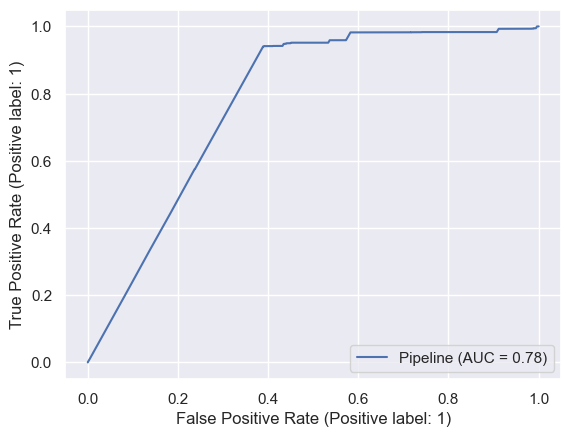

Total time elapsed for predictions: 1.48


In [48]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type","lower", "original_index","upper","labels_max","labels_average"]]]
    
y = stateless_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
         ('LR', LogisticRegression(random_state=0))
    ])    
    time_train_start = time.time()

    pipe.fit(X_train, y_train)
    
    time_train_end = time.time()
    
    print(f"Training time elapsed: {(time_train_end - time_train_start):.2f}")

    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateless += (end_fold - start_fold)
    
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show() 

print(f"Total time elapsed for predictions: {(total_prediction_time_stateless):.2f}")


In [49]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 1.477
Time to evaluate a single data point: 0.00000195


In [50]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.939925,0.619803,0.747013,462858.000000
1,0.610665,0.937707,0.739648,294353.000000
accuracy,0.743383,0.743383,0.743383,0.743383
macro avg,0.775295,0.778755,0.743330,757211.000000
weighted avg,0.811931,0.743383,0.744150,757211.000000


## This shows that the although both the feature selections improve accuracy from the base model, RFE feature selection gives us slightly better results as the accuracy goes upto 0.75. Prediction time for this model is also lesser as compared to the model with features selected by anova so we conclude that RFE is a better feature selection technique for the given dataset

## ----------------xxxxxxxxxxxxxxxxxxxxxxxx----------------------------------------------